In [1]:
import math
import numpy as np

# Normalises X into a value between -Pi and Pi
def norm_circular(x):
    return ((x + math.pi) % (2 * math.pi)) - math.pi

# Turns a value between -pi and pi into a point around the unit circle with its value as the argument:
def arg_convert(x):
    return complex(math.cos(x), math.sin(x))

# produces the "mean" of a set of phases, in that the different complex phases are meaned together and the result is the argument of that mean
# The tuple returned is a pair that contains the angle of this mean and the mean itself respectively.  
# This is effectively the same as taking the cos and sine means for all the phases 
# (which is how Pikovsky, Rosenblaum and Kurths [Cambridge textbook] does it)
def angular_mean(x):
    x = np.array(list(map(arg_convert, map(norm_circular, x))))
    m = np.mean(x)
    return (np.angle(m), m)

# Based off of the cosine angular difference
# The angle between two vectors is theta where cos(theta) = A dot B / ||A|| * ||B||
# As the magnitude of the phases across the unit circle is equal to 1, then this is just A dot B where A is (cos(x),sin(x)) and B is similar
def angular_difference(x, y):
    return math.acos(math.cos(x) * math.cos(y) + math.sin(x) * math.sin(y))

 

(-1.1140812848854695, (0.014022249803864193-0.028537392467299725j))


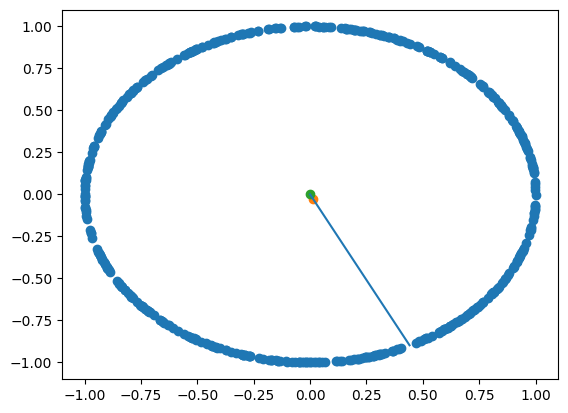

In [2]:
import numpy as np
import matplotlib.pyplot as plt


#Verify that the above functions work as expected...
x = np.random.random(500) * 100
z = np.array(list(map(arg_convert, map(norm_circular, x))))
# Should produce a unit circle shape
plt.scatter(np.real(z), np.imag(z))
# plot the mean (expected value is 0,0 since this is a randomly generated set of points)
am = angular_mean(x)[1]
aa = angular_mean(x)[0]
plt.scatter(np.real(am), np.imag(am))
#draws a line to verify the angle produced
print(angular_mean(x))
plt.plot((0, math.cos(aa)), (0, math.sin(aa)))
plt.scatter(0,0)


In [3]:
   
#Performs a single discrete instance of kuraomoto model

# K is the coupling matrix
# phi is the vector of phases of each oscillator
# o is the vector of natural frequencies for each oscillator
# dt is the time differential of the update.
# noise is the variance of the perbetuation
def single_kuramoto(K, phi, dt, o, noise, rng = None):
    phi_updated = phi.copy()
    for i in range(len(phi)):
        # get sine offsets
        sine = np.array(list(map(lambda x: math.sin(x - phi[i]), phi)))
        # Extract inbound column on coupling matrix
        k = np.take(K, i, axis=1)[0]
        # construct update term
        dx = np.mean(sine @ k.T) + o[i]
        # Construct Noise term 
        if rng is None:
            noise_term = (noise * np.random.normal())
        else:
            noise_term = noise * rng.normal()
        phi_updated[i] += (dx + noise_term) * dt # an issue with this is that larger time values may be sampled incorrectly
        phi_updated[i] = norm_circular(phi_updated[i])
    return phi_updated



#Calculates the Sigma value for a given coupled matrix and variance
def sigma(K, noise):
    #See section 2 of appendix from lizier paper
    N = K.shape[0]
    G = 1/N * np.ones((N,N))
    U = np.eye(N) - G
    print(N)
    print(G)
    print(U)




In [4]:
#sigma(np.array(([1,2,3],[4,5,6],[7,8,9])), 1, 1)

In [5]:
#b = np.random.random((500,500))
#print(b)

#sorted(np.linalg.eigvals(b))

In [6]:
il = [1,2,3]
for i in range(len(il)):
    if i == 2:
        del il[i]
        i -= 1
    print(il[i])

1
2
2


In [7]:
import numpy as np
import networkx as nx
import itertools as iter

#Helper function to replace link edges in Watts Strogatz function
def _watts_strogatz_replace_helper(x, rng, n, p):
    if rng.random() < p:
        repl = rng.integers(0, n - 2)
        z = sorted(x)
        repl = repl + 1 if repl >= z[0] else repl
        repl = repl + 1 if repl >= z[1] else repl
        return (x[0], repl)
    return x
            

# Partially based upon: 
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html#networkx.generators.random_graphs.watts_strogatz_graph
def watts_strogatz_directed(n, k, p, seed=None):
    rng = np.random.default_rng(seed = seed)
    # construct edge list
    edge_list = iter.permutations((i for i in range(n)), 2)
    # only connect the K nearest neighbours,
    # n is the number of nodes here.
    edge_list = filter(lambda x: abs(x[0] - x[1]) % (n - k/2) <= k/2, edge_list)
    # probabilistically remove edges:
    edge_list = map(lambda x: _watts_strogatz_replace_helper(x, rng, n, p), edge_list)
    edge_list = list(edge_list)
    if len(edge_list) == 0:
        return None
    G = nx.DiGraph(edge_list)
    return G


# Also based upon:
# 
def weak_connected_ws_directed(n, k, p, tries = 100,seed = None):
    for t in range(tries):
        if seed is not None:
            seed = seed + 1
        G = watts_strogatz_directed(n, k, p, seed = seed)
        if G is None:
            continue
        if nx.is_weakly_connected(G) and len(G.nodes) == n:
            return G
    return None

def strong_connected_ws_directed(n, k, p, tries = 100,seed = None):
    for t in range(tries):
        if seed is not None:
            seed = seed + 1
        G = watts_strogatz_directed(n, k, p, seed = seed)
        if G is None:
            continue
        if nx.is_strongly_connected(G) and len(G.nodes) == n:
            return G
    return None


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.connected_watts_strogatz_graph(10, 3, 0)
#nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')
#G = strong_connected_ws_directed(25, 2, 0.7, seed = 123122131)

G = strong_connected_ws_directed(10, 2, 0.1, seed = 123122131)

nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')


ModuleNotFoundError: No module named 'networkx'

In [9]:
am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)

In [10]:

#np.linalg.eig(am)
#am[2][0] = 0
print(am)

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]]


In [11]:
#Normalises the sum of incoming edges to a target to 1
def coupling_normalisation(G):
    G = G.copy()
    T = G.transpose()
    for i in range(T.shape[0]):
        if np.sum(T[i]) == 0:
            continue
        T[i] /= np.sum(T[i])
    return np.matrix(T.transpose())

# Gets the eigenvalue of the zero mode (arrow phi_0), which is the leading eigenvalue
# Then checks if there are any other eigenvalues of 1.
def convergance_test(G):
    ev = sorted(np.linalg.eigvals(G), reverse = True)
    if ev[0] != 1 or ev[0] == ev[1]:
        return False
    return True

In [12]:
ng = coupling_normalisation(am)
print(ng)

[[0.         0.5        0.5        0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.33333334 0.5        0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.33333334 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.5        0.         0.         0.
  0.         0.         0.         0.5       ]
 [0.         0.5        0.         0.         0.         0.5
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5        0.
  0.5        0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.         0.5        0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.         0.5        0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.5        0.         0.5       ]
 [0.         0.         0.         

In [13]:
convergance_test(ng)

True

In [14]:
starting_state = [1,] + ([0,] * 9)
print(starting_state)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
old_state = np.array(single_kuramoto(ng, starting_state, 1, np.zeros((10)), 1))
for i in range(500):
    new_state = np.array(single_kuramoto(ng, old_state, 1, np.zeros((10)), 0.25))
    state_diff = new_state - old_state
    old_state = new_state
print(old_state)
print(state_diff)



[-1.15981803 -0.59300323 -1.44204692 -1.08223492 -0.46553824  0.13296301
 -1.24646822 -0.94445056 -1.22626901 -2.01740501]
[ 0.54192687 -0.15572229 -0.53911558  0.55445756 -0.32502284  0.88680992
 -0.67322431 -0.02941446  0.14376455 -0.26191614]


True


100%|██████████| 15000/15000 [00:20<00:00, 733.54it/s]


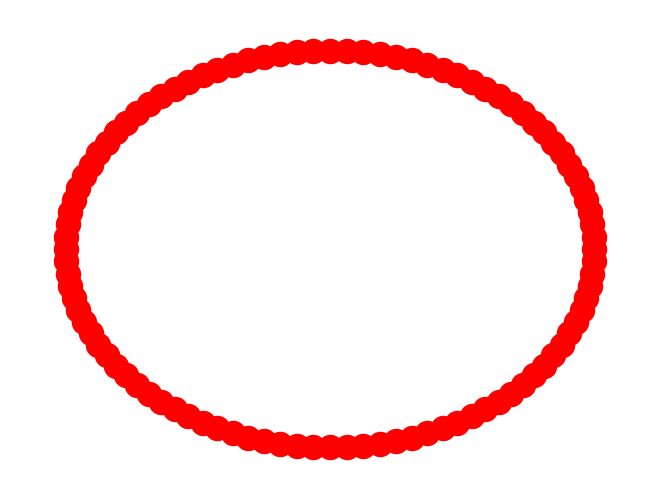

In [17]:
import kuramoto
import graphs as graphs
import networkx as nx
import numpy as np


N = 100
t = 1500
var = 0.15
# setup graph

# Seemingly fails in convergence, but converges eventually.
# try with t = 10000, and a 0.01 variance

G = strong_connected_ws_directed(N, 4, 0.001, seed = 123122131, tries = 500)


# draw graph 
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')
am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)
am = coupling_normalisation(am)
print(convergance_test(am))
out = kuramoto.kuramoto_runtime(am, t, var, seed=42, prog_bar = True)
state_list, order_parameters, sigma_squared = (out["all_states"], out["order_parameters"], out["sigma_squared"])
old_state = state_list[-1]

Order parameter strength:  0.9689954266795717


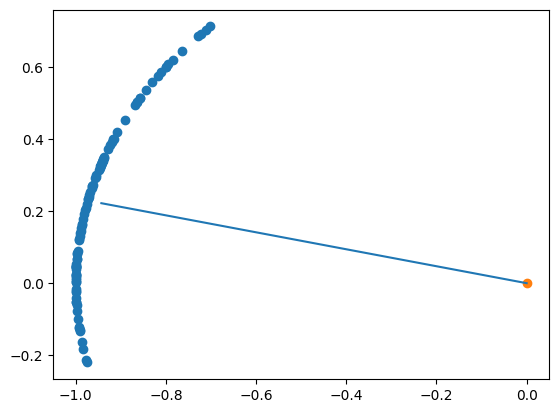

In [18]:
def map_colour(a):
    r = (math.cos(a))
    g = (math.cos(a - (math.pi/1.5)))
    b = (math.cos(a + (math.pi/1.5)))
    out = np.array((r,g,b))
    out = (out + 1) / 2
    return out

def map_colour_rbg(a):
    r = (math.cos(a))
    g = (math.cos(a - (math.pi/1.5)))
    b = (math.cos(a + (math.pi/1.5)))
    out = np.array((r,g,b))
    #ReLU correction for colours
    out = list(map(lambda x: x * (x > 0), out))
    return out

#Plot end-state oscillator phases
z = np.array(list(map(arg_convert, map(norm_circular, old_state))))
c = np.array(list(map(map_colour_rbg, np.angle(z))))
plt.scatter(np.real(z), np.imag(z))
m = angular_mean(old_state)[1]
plt.plot((0, np.real(m)), (0, np.imag(m)))
plt.scatter(0,0)

print("Order parameter strength: ", math.sqrt(np.real(m) ** 2 + np.imag(m) ** 2))

In [19]:
nsl = []

step = 10

sl = len(state_list) // step
for i in range(sl):
    nsl.append(state_list[i * step])

0it [00:00, ?it/s]

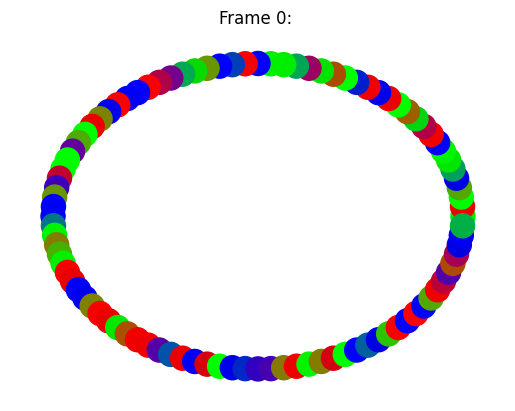

In [20]:
from tqdm import tqdm
import matplotlib.animation as anim
fig, ax = plt.subplots()
artists = []

l = len(nsl)



def update(num):
    ax.clear()
    current_state = nsl[num]
    c = np.array(list(map(map_colour_rbg, current_state)))
    nx.draw(G, pos=nx.circular_layout(G), node_color=c, edge_color='b', ax = ax)
    ax.set_title("Frame %d: "%(num))
    ax.set_xticks([])
    ax.set_yticks([])
    pbar.update(1)
    return ax

pbar = tqdm()
ani = anim.FuncAnimation(fig=fig, func=update, frames=l, interval=100)
pbar.close()

In [21]:
animate = False
if animate:
    pbar = tqdm(total = sl)
    ani.save(filename="original.gif", writer="pillow")
    pbar.close()

In [22]:
from tqdm import tqdm
import matplotlib.animation as anim
from functools import partial

def update_anim(num, G=None, nsl=None, pbar=None, ax=None):
        ax.clear()
        current_state = nsl[num]
        c = np.array(list(map(map_colour_rbg, current_state)))
        nx.draw(G, pos=nx.circular_layout(G), node_color=c, edge_color='b', ax = ax)
        ax.set_title("Frame %d: "%(num))
        ax.set_xticks([])
        ax.set_yticks([])
        pbar.update(1)
        return ax


def make_anim(filename, G, state_list, step):
    sl = len(state_list) // step
    pbar = tqdm(total = sl)
    nsl = []
    for i in range(sl):
        nsl.append(state_list[i * step])
    fig, ax = plt.subplots()
    f = partial(update_anim, G=G, nsl=nsl, pbar=pbar, ax=ax)
    ani = anim.FuncAnimation(fig=fig, func=f, frames=sl, interval=100)
    ani.save(filename=filename, writer="pillow")
    pbar.close()


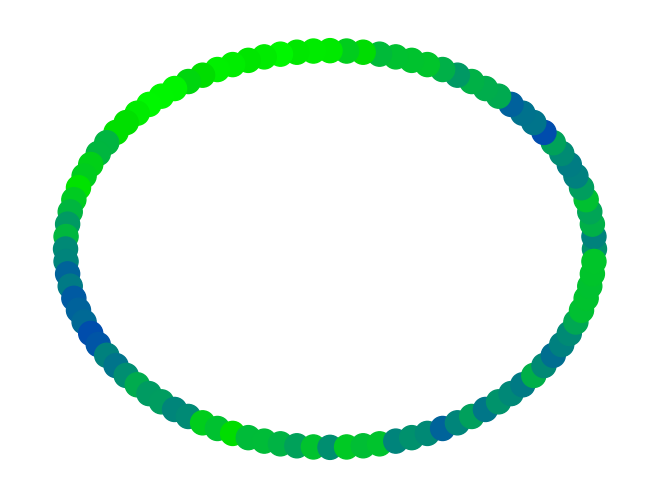

In [23]:
c = np.array(list(map(map_colour_rbg, state_list[-1])))


nx.draw(G, pos=nx.circular_layout(G), node_color=c, edge_color='b')


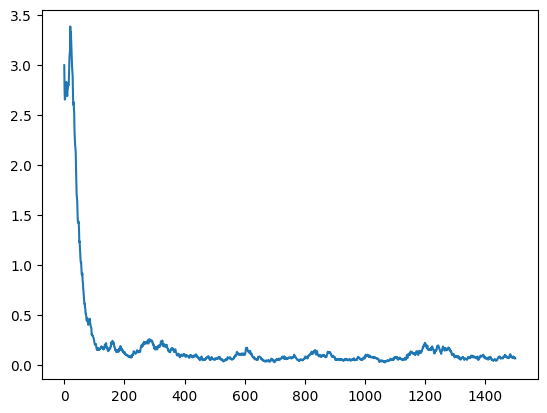

In [24]:
# Convergence

plt.plot([i for i in range(len(sigma_squared))], sigma_squared)


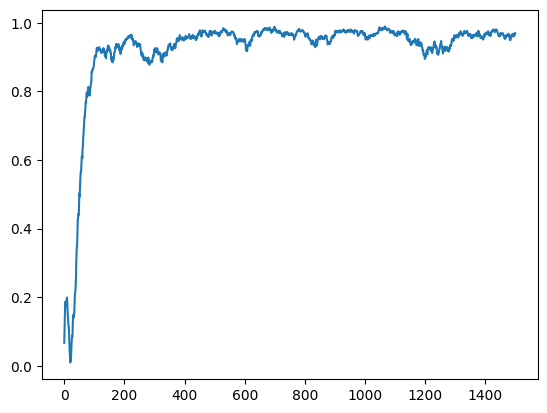

In [25]:
plt.plot([i for i in range(len(order_parameters))], order_parameters)


In [ ]:
#make_anim("/tmp/kuramoto1.gif", G, state_list, 10)

NameError: name 'coupling_normalisation' is not defined

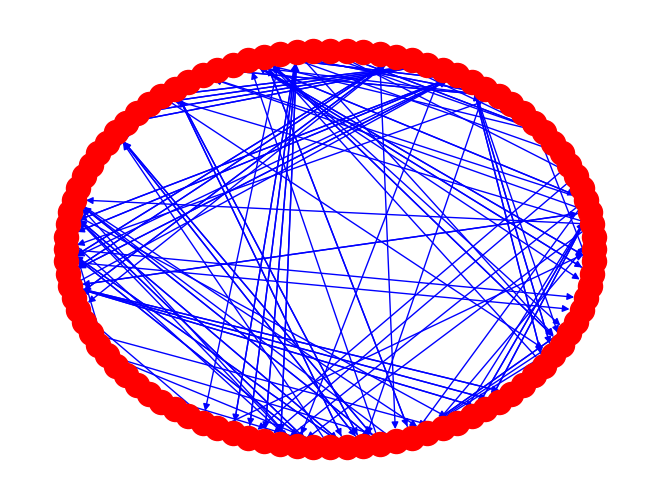

In [2]:
import kuramoto
import graphs as graphs
import networkx as nx
import numpy as np


N = 100
t = 1000
var = 0.5
# setup graph

# Seemingly fails in convergence, but converges eventually.
# try with t = 10000, and a 0.01 variance
#G = strong_connected_ws_directed(N, 4, 0.001, seed = 123122131, tries = 500)

G = graphs.strong_connected_ws_directed(N, 4, 0.15, seed = 123122131, tries = 500)

# draw graph 
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')
am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)
am = coupling_normalisation(am)
print(convergance_test(am))
state_list, order_parameters, sigma_squared = kuramoto.kuramoto_runtime(am, t, var, 42, prog_bar = True)

old_state = state_list[-1]

In [ ]:
#make_anim("/tmp/kuramoto2.gif", G, state_list, 5)

Order parameter strength:  0.8194259665852268


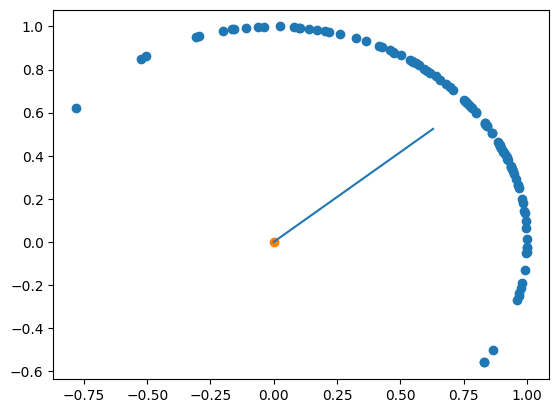

In [ ]:
#Plot end-state oscillator phases
z = np.array(list(map(arg_convert, map(norm_circular, old_state))))
plt.scatter(np.real(z), np.imag(z))
m = angular_mean(old_state)[1]
plt.plot((0, np.real(m)), (0, np.imag(m)))
plt.scatter(0,0)

print("Order parameter strength: ", math.sqrt(np.real(m) ** 2 + np.imag(m) ** 2))




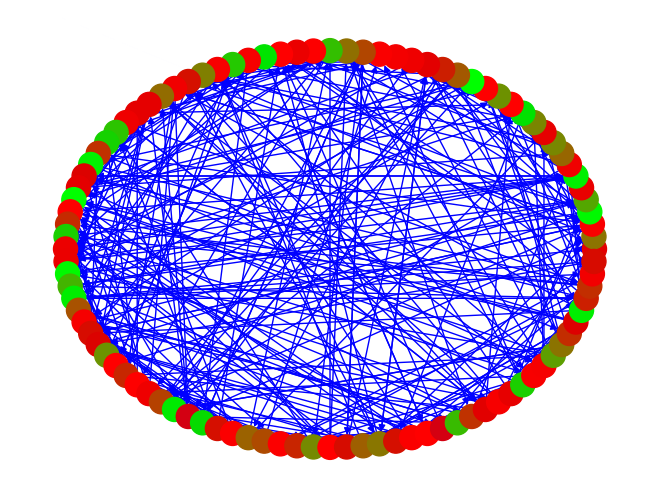

In [ ]:
c = np.array(list(map(map_colour_rbg, np.angle(z))))


nx.draw(G, pos=nx.circular_layout(G), node_color=c, edge_color='b')


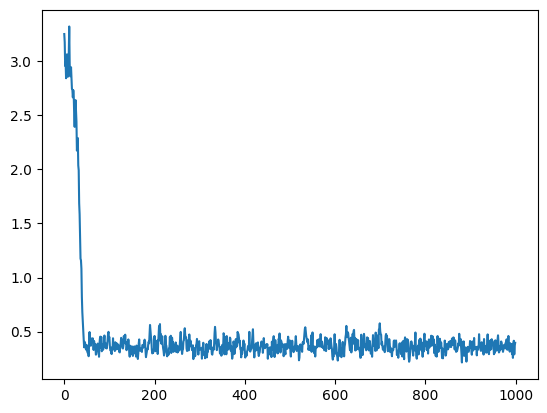

In [ ]:
# Convergence

plt.plot([i for i in range(len(sigma_squared))], sigma_squared)


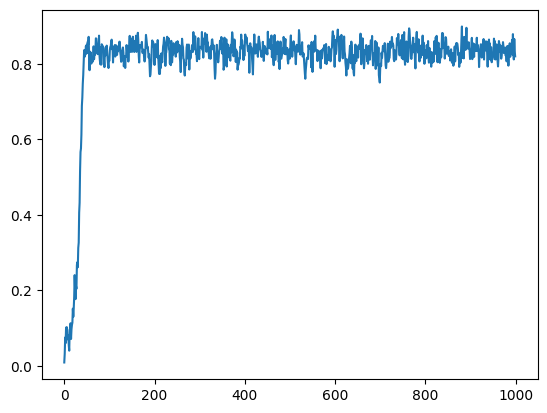

In [ ]:
plt.plot([i for i in range(len(order_parameters))], order_parameters)


matrix([[0.        , 0.25      , 0.25      , 0.2       , 0.25      ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.        , 0.25      , 0.        , 0.25      ,
         0.33333334, 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.25      , 0.        , 0.        , 0.        ,
         0.33333334, 0.16666667, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.25      ,
         0.        , 0.        , 0.25      , 0.25      , 0.33333334],
        [0.        , 0.        , 0.        , 0.2       , 0.        ,
         0.        , 0.16666667, 0.        , 0.25      , 0.33333334],
        [0.        , 0.25      , 0.25      , 0.        , 0.        ,
         0.        , 0.16666667, 0.25      , 0.        , 0.        ],
        [0.        , 0.        , 0.25      , 0.        , 0.        ,
         0.33333334, 0.        , 0.25      , 0.25      , 0.        ],
        [0.        , 0.25  

True

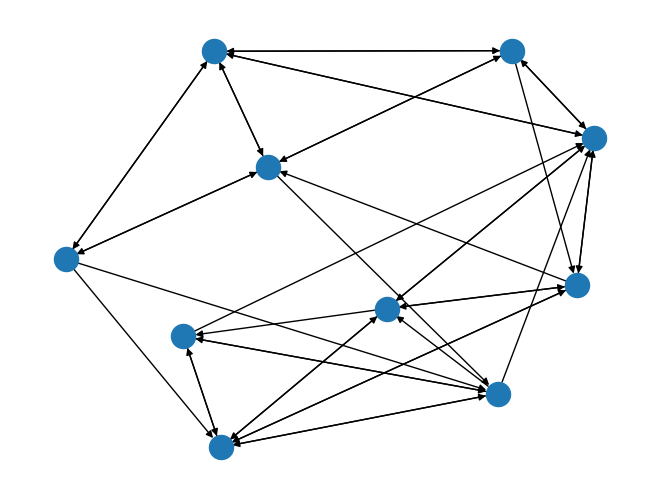

In [ ]:
G = strong_connected_ws_directed(10, 4, 0.2, seed = 123122131)
nx.draw(G)

am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)
am = coupling_normalisation(am)
display(am)

convergance_test(am)

In [ ]:
import linear

display(am)

display(linear.linear_coupling_matrix(am))

matrix([[0.        , 0.25      , 0.25      , 0.2       , 0.25      ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.        , 0.25      , 0.        , 0.25      ,
         0.33333334, 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.25      , 0.        , 0.        , 0.        ,
         0.33333334, 0.16666667, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.25      ,
         0.        , 0.        , 0.25      , 0.25      , 0.33333334],
        [0.        , 0.        , 0.        , 0.2       , 0.        ,
         0.        , 0.16666667, 0.        , 0.25      , 0.33333334],
        [0.        , 0.25      , 0.25      , 0.        , 0.        ,
         0.        , 0.16666667, 0.25      , 0.        , 0.        ],
        [0.        , 0.        , 0.25      , 0.        , 0.        ,
         0.33333334, 0.        , 0.25      , 0.25      , 0.        ],
        [0.        , 0.25  

matrix([[-1.        ,  0.25      ,  0.25      ,  0.2       ,  0.25      ,
         -0.        , -0.        , -0.        , -0.        , -0.        ],
        [ 0.5       , -1.        ,  0.25      , -0.        ,  0.25      ,
          0.33333334, -0.        , -0.        , -0.        , -0.        ],
        [ 0.5       ,  0.25      , -1.        , -0.        , -0.        ,
          0.33333334,  0.16666667, -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -1.        ,  0.25      ,
         -0.        , -0.        ,  0.25      ,  0.25      ,  0.33333334],
        [-0.        , -0.        , -0.        ,  0.2       , -1.        ,
         -0.        ,  0.16666667, -0.        ,  0.25      ,  0.33333334],
        [-0.        ,  0.25      ,  0.25      , -0.        , -0.        ,
         -1.        ,  0.16666667,  0.25      , -0.        , -0.        ],
        [-0.        , -0.        ,  0.25      , -0.        , -0.        ,
          0.33333334, -1.       

In [ ]:
import linear

#Performs a single discrete instance of linearised O-U model

# K is the coupling matrix
# phi is the vector of phases of each oscillator
# o is the vector of natural frequencies for each oscillator
# dt is the time differential of the update.
# noise is the variance of the perbetuation
def single_linear(K, phi, dt, o, noise, rng = None):
    phi_updated = phi.copy()
    for i in range(len(phi)):
        # Extract inbound column on coupling matrix
        k_i = np.take(K, i, axis=1)[0]
        # construct update term
        dx = phi @ k_i.T
        # Construct Noise term 
        if rng is None:
            noise_term = (noise * np.random.normal())
        else:
            noise_term = noise * rng.normal()

        phi_updated[i] += (dt * dx) + (noise_term * math.sqrt(dt))
    return phi_updated
    

# Runs t iterations of the Linear model
# Comments pending
def linear_runtime(C, t, var,dt = 1, seed = None, prog_bar = False):
    #K = -(I - C)
    K = linear.linear_coupling_matrix(C)
    N = K.shape[0]
    rng = np.random.default_rng(seed = seed)
    starting_state = np.array((rng.random(N) * (2 * math.pi)) - math.pi)
    state_list = [starting_state]
    sigma_squared = []
    order_parameters = []

    # A simple progress bar as part of TQDM
    iter = range(t)
    if prog_bar:
        iter = tqdm(iter)
    #C = normalise_graph_linear(K, dt)
    prev_state = state_list[0]
    for i in iter:
        new_state = np.array(single_linear(K, prev_state, dt, np.zeros((N)), var, rng = rng))
        mean = np.mean(new_state)
        # Only record statistics when descretised time is non-fractional
        if (i % math.floor(1 / dt) == 0):
            # Fake order parameter, meaningless but will be ploted just for comparison
            mv = angular_mean(new_state)[1]
            order_parameter_strength = math.sqrt(np.real(mv) ** 2 + np.imag(mv) ** 2)
            # Calculate Sigma Squared
            current_sigma_squared = ((np.sum((new_state - mean) ** 2)) / N)
            #print(new_state)
            state_list.append(new_state)
            sigma_squared.append(current_sigma_squared)
            order_parameters.append(order_parameter_strength)
        prev_state = new_state - mean
    return (state_list, order_parameters, sigma_squared) 



In [ ]:
N = 100
t = 1000
dt = 0.01
var = 0.01

G =  (np.ones(N) - np.eye(N))/(N - 1)
print(np.sum(np.take(G, 0, axis=1)))

0.9999999999999998


True


100%|██████████| 10000/10000 [00:15<00:00, 661.76it/s]


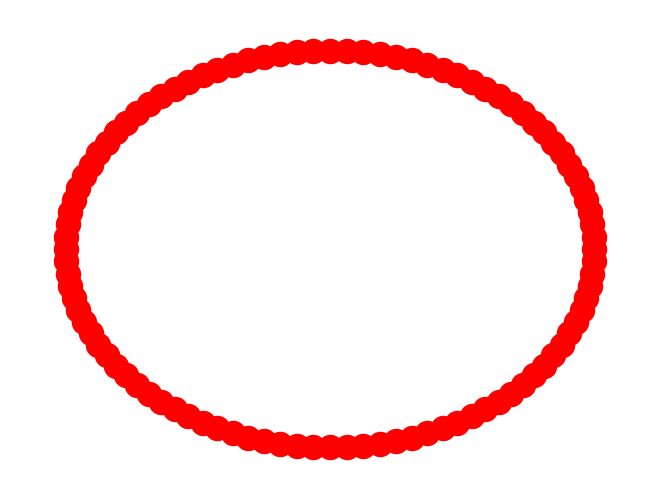

In [ ]:
import kuramoto
import graphs as graphs
import networkx as nx
import numpy as np


N = 100
t = 1000
dt = 0.1
var = 0.1
# setup graph

# Seemingly fails in convergence, but converges eventually.
# try with t = 10000, and a 0.01 variance
#G = strong_connected_ws_directed(N, 4, 0.001, seed = 123122131, tries = 500)

G = strong_connected_ws_directed(N, 4, 0.001, seed = 123122131, tries = 500)

# draw graph 
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')
am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)
am = coupling_normalisation(am)
print(convergance_test(am))
state_list, order_parameters, sigma_squared = linear.linear_runtime(am, round(t * (1/dt)), var, dt = dt, seed = 42, prog_bar = True)

old_state = state_list[-1]





In [ ]:
print(np.round(state_list[1000],3))

[ 0.246  0.099  0.13   0.281  0.23   0.074  0.131  0.249  0.108  0.101
  0.013  0.014  0.005 -0.082 -0.008  0.042  0.035 -0.083 -0.036 -0.026
 -0.054 -0.098 -0.267 -0.066 -0.152 -0.176 -0.189 -0.283 -0.285 -0.172
 -0.288 -0.22  -0.269 -0.222 -0.195 -0.148 -0.148  0.002  0.    -0.072
  0.02  -0.121  0.032 -0.025 -0.022 -0.244 -0.088 -0.215 -0.133 -0.251
 -0.044 -0.081 -0.062  0.018  0.003  0.012 -0.012  0.14  -0.061  0.035
 -0.083  0.034 -0.043 -0.138 -0.271 -0.28  -0.216 -0.152 -0.028 -0.051
  0.043  0.053  0.024 -0.069  0.018  0.138 -0.102 -0.032 -0.079  0.027
 -0.046  0.124 -0.045  0.057 -0.041  0.067 -0.023  0.161  0.243  0.359
  0.36   0.29   0.253  0.384  0.179  0.363  0.246  0.304  0.308  0.341]


Order parameter strength:  0.9860921245039935


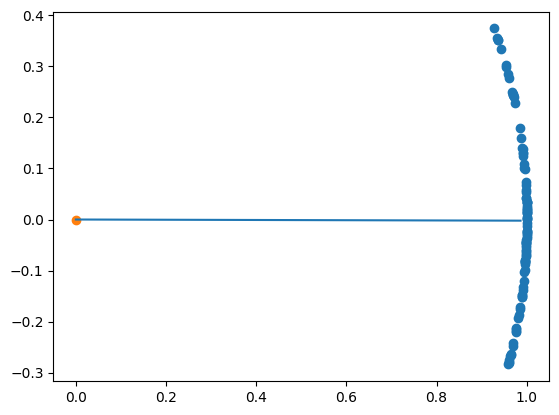

In [ ]:
#Plot end-state oscillator phases
z = np.array(list(map(arg_convert, map(norm_circular, old_state))))
plt.scatter(np.real(z), np.imag(z))
m = angular_mean(old_state)[1]
plt.plot((0, np.real(m)), (0, np.imag(m)))
plt.scatter(0,0)

print("Order parameter strength: ", math.sqrt(np.real(m) ** 2 + np.imag(m) ** 2))




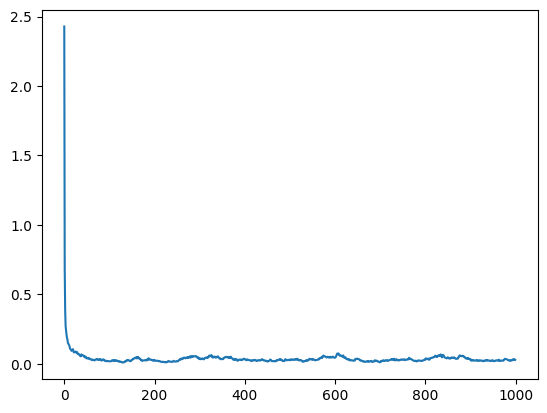

In [ ]:
# Convergence

plt.plot([i for i in range(len(sigma_squared))], sigma_squared)


In [ ]:
#K = linear_coupling_matrix(am)
import sigma
cv_p = sigma.calculate_covariance_matrix(am)
#cv_isa = isa_sigma.projectedCovarianceMatrixForContinuousDynamicalProcesses(am)

print(0.1 ** 2 * np.trace(cv_p) * 1/am.shape[0]) 
#print(0.1 ** 2 * np.trace(cv_isa) * 1/am.shape[0])
print(np.mean(sigma_squared[-750]))

0.03272224170061364
0.017476591900095963


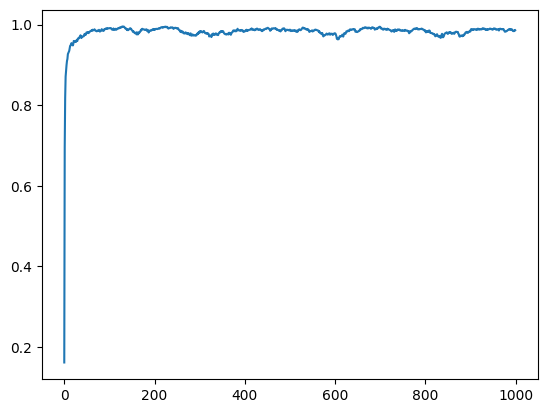

In [ ]:
plt.plot([i for i in range(len(order_parameters))], order_parameters)


In [ ]:
#make_anim("linear_normalised_slow.gif", G, state_list[0:100], 1)

Notes:

* use K for linearised equation and not C.
* Simulate Euler's and Heun's method
* Simulate both discrete and continuous time processes and compare the efficiencies of all processes.
* Don't normalise matrix before linearisation, include linear term when performing euler method.

* For linearisation, change circular norm so that it properly normalises around a frame of reference (mean of value)

True


100%|██████████| 10000/10000 [00:14<00:00, 678.63it/s]


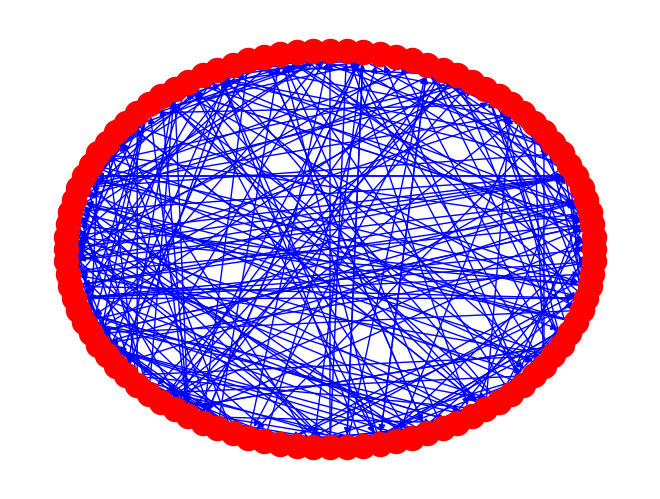

In [ ]:
import kuramoto
import graphs as graphs
import networkx as nx
import numpy as np


N = 100
t = 1000
var = 0.1
dt = 0.1
# setup graph

# Seemingly fails in convergence, but converges eventually.
# try with t = 10000, and a 0.01 variance
#G = strong_connected_ws_directed(N, 4, 0.001, seed = 123122131, tries = 500)

G = graphs.strong_connected_ws_directed(N, 4, 0.7, seed = 123122131, tries = 500)

# draw graph 
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')
am = nx.to_numpy_array(G)
am = np.matrix(am).astype(np.float32)
am = coupling_normalisation(am)
print(convergance_test(am))
state_list, order_parameters, sigma_squared = linear.linear_runtime(am, round(t * (1/dt)), var, dt = dt, seed = 42, prog_bar = True)

old_state = state_list[-1]

Order parameter strength:  0.9964265356234259


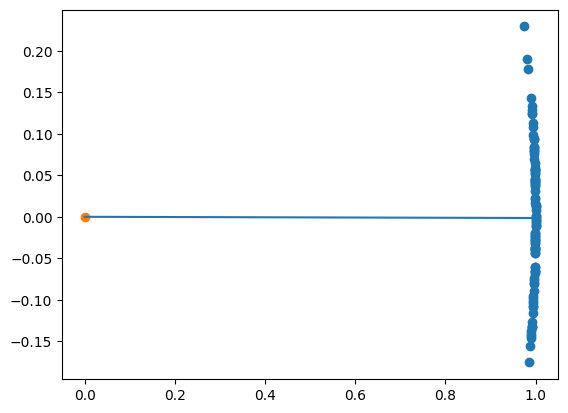

In [ ]:
#Plot end-state oscillator phases
z = np.array(list(map(arg_convert, map(norm_circular, old_state))))
plt.scatter(np.real(z), np.imag(z))
m = angular_mean(old_state)[1]
plt.plot((0, np.real(m)), (0, np.imag(m)))
plt.scatter(0,0)

print("Order parameter strength: ", math.sqrt(np.real(m) ** 2 + np.imag(m) ** 2))




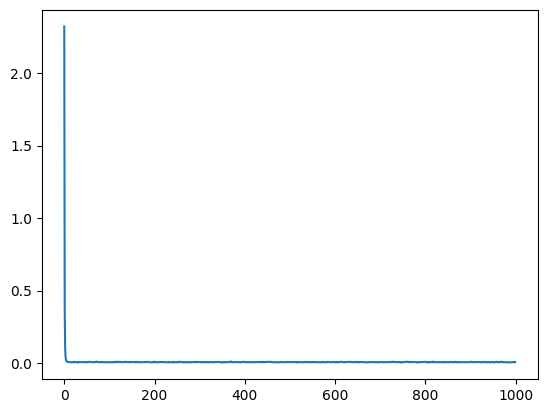

In [ ]:
# Convergence

plt.plot([i for i in range(len(sigma_squared))], sigma_squared)


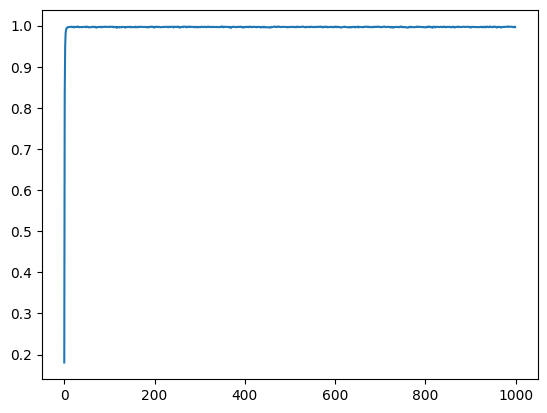

In [ ]:
plt.plot([i for i in range(len(order_parameters))], order_parameters)


In [ ]:
#make_anim("linear_slow_normalised.gif", G, state_list, 5)

In [ ]:
import numpy as np

#import isa_sigma

def centering_matrix(C):
    return np.eye(C.shape[0]) - (np.ones(C.shape) * 1/(C.shape[0]))

#eq 12/15 from Lizier paper.
#eq 54/65 from Appendix content

#eq 65 only valid upon convergence (but what if I don't want the linear approach to converge??????)

# U^T covariance matrix U
epsilon = 1.19e-07

def calculate_covariance_matrix(C, s = 2, err = epsilon * 1e4, max_iter = 10000):
    U = centering_matrix(C)
    diff = U * 0.5

    projected_covariance = U * 0.5
    i = 0
    while np.any(abs(diff) >= epsilon) and i < max_iter:
        # Why add them instead of @?
        diff = ((U @ C.T @ diff) + (diff @ C @ U)) / 2
        projected_covariance += diff
        i += 1
    if i == max_iter or np.any(projected_covariance == np.nan) or np.any(projected_covariance == np.inf):
        print("Convergence failure!")
    return projected_covariance




In [ ]:
import sigma

centering_matrix(np.eye(10)) @ centering_matrix(np.eye(10))

#K = linear_coupling_matrix(am)

cv_p = sigma.calculate_analytical_variance_cont(am, 0.1)
d_p = sigma.calculate_analytical_variance_disc(am, 0.1)
#cv_isa = isa_sigma.projectedCovarianceMatrixForContinuousDynamicalProcesses(am)

print(cv_p)
print(d_p) 
#print(0.1 ** 2 * np.trace(cv_isa) * 1/am.shape[0])
print(np.mean(sigma_squared[-500]))

0.006183570983715091
0.0099
0.006333237605597013


In [ ]:
# Start with low noise
# 

In [ ]:
from functools import partial

def list_partial(func, args, kwargs):
    print(args)
    if args is None:
        args = []
    print(kwargs)
    if kwargs is None:
        kwargs = []
    return func(*args,**kwargs)

In [ ]:
def sum(x = 5, y = 2):
    return x + y
list_partial(sum, None, {"x": 10, "y": 20})

None
{'x': 10, 'y': 20}


30

In [1]:
import autorun2 as ar2

In [11]:
ar2.split_all(40, 960)

[[0,
  40,
  80,
  120,
  160,
  200,
  240,
  280,
  320,
  360,
  400,
  440,
  480,
  520,
  560,
  600,
  640,
  680,
  720,
  760,
  800,
  840,
  880,
  920],
 [1,
  41,
  81,
  121,
  161,
  201,
  241,
  281,
  321,
  361,
  401,
  441,
  481,
  521,
  561,
  601,
  641,
  681,
  721,
  761,
  801,
  841,
  881,
  921],
 [2,
  42,
  82,
  122,
  162,
  202,
  242,
  282,
  322,
  362,
  402,
  442,
  482,
  522,
  562,
  602,
  642,
  682,
  722,
  762,
  802,
  842,
  882,
  922],
 [3,
  43,
  83,
  123,
  163,
  203,
  243,
  283,
  323,
  363,
  403,
  443,
  483,
  523,
  563,
  603,
  643,
  683,
  723,
  763,
  803,
  843,
  883,
  923],
 [4,
  44,
  84,
  124,
  164,
  204,
  244,
  284,
  324,
  364,
  404,
  444,
  484,
  524,
  564,
  604,
  644,
  684,
  724,
  764,
  804,
  844,
  884,
  924],
 [5,
  45,
  85,
  125,
  165,
  205,
  245,
  285,
  325,
  365,
  405,
  445,
  485,
  525,
  565,
  605,
  645,
  685,
  725,
  765,
  805,
  845,
  885,
  925],
 [6,
  46,